In [515]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.naive_bayes import MultinomialNB

In [494]:
# Load data
data = pd.read_csv('https://otf.ca/sites/default/files/OTF-Grants_since2000.csv')

# Clustering

In [495]:
# Clean data
data = data.drop(columns=['Funding Org:Org subventionnaire', 'Country Served:Pays servis', 'Province Served:Province servis', 'Cross-catchment indicator:Indicateur interrégional', 'Co-Application:Co-demandeurs', 'Description (French/Français)', 'Grant Result:Résultat de subvention','Rescinded/Recovered:Révoqué/récupéré','Rescinded/Recovered Initiated By:Révoqué/récupéré intié par','Amount Rescinded/Recovered:Montant révoqué/récupéré', 'Last modified:Mise à jour'])
data.columns = ['fiscal_year','grant_program','geographical_area','identifier','org_name','submission_date', 'approval_date', 'amount_applied', 'amount_awarded', 'planned_duration', 'description', 'program_area', 'budget_fund', 'org_incorporation_num', 'org_charitable_reg_num', 'org_city', 'org_postcode', 'population_served', 'age_group']
description = pd.DataFrame(data, columns = ['description'])

# Remove structured text and keep only free-form text
a = description['description'].str.split('programs for Ontarians by ').str[1].dropna()
b = description['description'].str.split('grant over \d+ years to ').str[1].dropna()
c = description['description'].str.split('rebuild and recover from impacts of COVID-19 by ').str[1].dropna()
d = description['description'].str.split('grant over \d+ months to ').str[1].dropna()
e = description['description'].str.split('\$\d+( \w+|[\d,]+) over \d+ months to ').str[2].dropna()
f = description['description'].str.split('\$\d+( \w+|[\d,]+) over one year to ').str[2].dropna()
g = description['description'].str.split('\$\d+( \w+|[\d,]+) over two years to ').str[2].dropna()
h = description['description'].str.split('\$\d+( \w+|[\d,]+) over three years to ').str[2].dropna()
i = description['description'].str.split('\$\d+( \w+|[\d,]+) over six months to ').str[2].dropna()
j = description['description'].str.split('This project aims to ').str[1].dropna()

description_clean = pd.concat([a, b, c, d, e, f, g, h, i, j], axis=0,ignore_index=False)
description_clean = description_clean.to_frame()

add_indices = pd.Index(range(27952)).difference(description_clean.index)
add_df = pd.DataFrame(index=add_indices, columns=description_clean.columns).fillna(description)
description_clean = pd.concat([description_clean, add_df])

In [584]:
# Apply lemmatization to reduce redundancy
recompute = False

if recompute:
    lemmatizer = WordNetLemmatizer()
    # get_wordnet_pos from Selva Prabhakaran @ Machine Learning Plus
    # https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    descriptions = []
    for i in description_clean['description']:
        descriptions.append(' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(i.lower())]))
    pd.DataFrame(descriptions).to_csv('descriptions.csv', index=False, header=False)

else:
    descriptions = pd.read_csv('descriptions.csv', header=None)

In [585]:
# Extract features
descriptions.columns = ['description']
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features = 300, stop_words = 'english')
counts_sparse = vectorizer.fit_transform(descriptions['description'])
counts = pd.DataFrame(counts_sparse.toarray(), index=description_clean.index, columns=vectorizer.get_feature_names())
counts = counts.drop(counts.columns[0:11], axis=1) 

In [586]:
counts

,_x000d_,ability,able,aboriginal,access,accessibility,accessible,active,activity,additional,...,water,website,wellbeing,woman,work,workshop,year,york,young,youth
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.263767,0.0,0.0,0.0000
27946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.293509,0.0,0.0,0.0000
27949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.194664,0.0,0.0,0.0000
27950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000


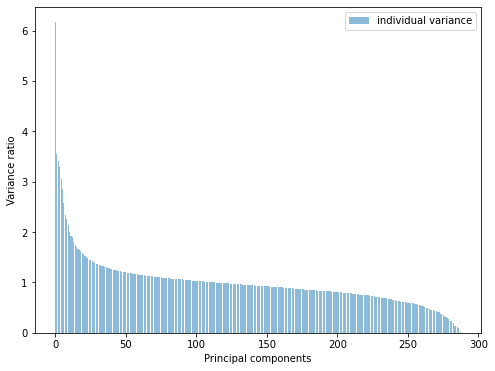

In [421]:
# Visualize variance across features to reduce dimensions
enconder = LabelEncoder()
for col in counts.columns:
    counts[col] = enconder.fit_transform(counts[col])
    
counts_features = counts.iloc[:,1:289]
counts_label = counts.iloc[:,0]

scaler = StandardScaler()
counts_features = scaler.fit_transform(counts_features)
    
pca = PCA()
pca.fit_transform(counts_features)
pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(288), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [417]:
# Reduce feature dimensionality
pca2 = PCA(n_components=10)
pca2.fit(counts_features)
counts_reduced = pca2.transform(counts_features)

pca_variance2 = pca2.explained_variance_

In [418]:
# Apply model
clusterer = KMeans(n_clusters=6)
clusterer.fit(counts_reduced)
label = clusterer.predict(counts_reduced)
pd.DataFrame(counts).groupby(label).mean()

,abilities,able,aboriginal,access,accessibility,accessible,active,activities,activity,additional,...,website,wellbeing,women,work,workshops,year,years,york,young,youth
0,4.828531,3.897651,1.616439,65.994873,7.821416,44.982511,7.390159,78.387178,10.675385,2.663699,...,3.989348,0.233873,12.181049,13.550936,13.478676,57.933980,63.675385,4.250368,15.361223,315.572559
1,0.000000,0.000000,0.487544,10.736655,5.142349,16.060498,0.758007,9.976868,0.149466,0.097865,...,0.000000,0.845196,5.774021,34.343416,4.138790,4.233096,0.000000,2.631673,2.909253,44.786477
2,0.092453,0.000000,0.298113,12.290566,0.392453,0.875472,0.239623,3.520755,1.324528,0.628302,...,0.418868,1.269811,3.515094,1.562264,5.647170,2.126415,1.113208,0.643396,9.298113,3258.567925
3,0.000000,49.412451,0.215953,59.042802,0.301556,1.184825,0.000000,1.891051,2.048638,0.000000,...,0.000000,240.824903,11.523346,6.247082,2.766537,0.653696,0.000000,0.494163,5.787938,76.686770
4,0.000000,0.015898,0.034976,62.853736,1.780604,2.387917,0.481717,3.759936,0.000000,0.240064,...,0.049285,0.000000,0.122417,0.222576,3.476948,0.422893,1.801272,0.844197,1.965024,28.074722
5,1.127013,0.000000,0.000000,12.069767,8.416816,116.778175,508.246869,374.570662,49.601073,0.298748,...,0.109123,0.000000,1.003578,0.404293,1.518784,5.720930,1.449016,0.488372,3.413238,70.280859


In [479]:
label=pd.Series(label)
for i in label.unique():
    print(i==label)

0        True
1        True
2        True
3        True
4        True
         ... 
27948    True
27949    True
27950    True
27951    True
27952    True
Length: 27953, dtype: bool
0        False
1        False
2        False
3        False
4        False
         ...  
27948    False
27949    False
27950    False
27951    False
27952    False
Length: 27953, dtype: bool
0        False
1        False
2        False
3        False
4        False
         ...  
27948    False
27949    False
27950    False
27951    False
27952    False
Length: 27953, dtype: bool
0        False
1        False
2        False
3        False
4        False
         ...  
27948    False
27949    False
27950    False
27951    False
27952    False
Length: 27953, dtype: bool
0        False
1        False
2        False
3        False
4        False
         ...  
27948    False
27949    False
27950    False
27951    False
27952    False
Length: 27953, dtype: bool
0        False
1        False
2        False
3     

In [480]:
boolean_index = manual_label==4
boolean_index
# decision tree to see what's different between 4 and rest

0         True
1        False
2         True
3        False
4         True
         ...  
27948     True
27949     True
27950     True
27951     True
27952     True
Length: 27953, dtype: bool

# Classifier

In [474]:
# Preprocessing
vectorizer2 = TfidfVectorizer(ngram_range=(1,1), max_features = 300, stop_words = 'english')
counts_sparse2 = vectorizer2.fit_transform(description_clean['description'])
counts2 = pd.DataFrame(counts_sparse2.toarray(), index=description_clean.index, columns=vectorizer2.get_feature_names())
counts2 = counts2.drop(counts2.columns[0:11], axis=1) 

# Determine features
classif_data = pd.DataFrame(data, columns = ['grant_program'])
p_a = pd.get_dummies(data['program_area'])
p_s = pd.get_dummies(data['population_served'])
a_g = pd.get_dummies(data['age_group'])
classif_data = classif_data.join([p_a,p_s,a_g,counts2])
classif_data = classif_data[:-1]

In [475]:
# Split data
rs=3403459
training = classif_data.sample(22361, random_state=rs)
testing = classif_data.drop(training.index)
holdout = training.sample(5000, random_state=rs)
training = training.drop(holdout.index)

# Apply model - holdout
classifier = MultinomialNB()
holdout_observations = pd.DataFrame(holdout)[training.drop('grant_program', axis=1).columns]
classifier.fit(training.drop(['grant_program'],axis=1), training['grant_program'])

# Make prediction - holdout
holdout_prediction = classifier.predict(holdout_observations)

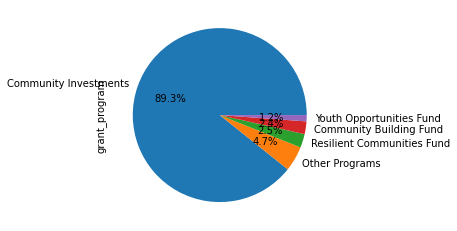

In [476]:
# Visualize prediction - holdout
holdout_prediction_df = pd.DataFrame(holdout_prediction, columns = ['grant_program'])
holdout_prediction_df['grant_program'].value_counts().plot.pie(autopct='%1.1f%%')

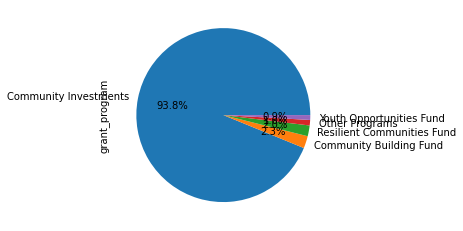

In [477]:
# Visualize training for comparison
training['grant_program'].value_counts().plot.pie(autopct='%1.1f%%')

In [478]:
# Get accuracy of holdout model
from sklearn.metrics import accuracy_score
estimated_accuracy = accuracy_score(holdout['grant_program'], holdout_prediction_df['grant_program'])
estimated_accuracy

0.9506

In [485]:
#pd.DataFrame(classif_data).to_csv('classifdata.csv', index=True, header=True)

In [156]:
#pd.DataFrame(description).to_csv('desc.csv', index=True, header=False)